In [1]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
from pickle import dump, load
import os
# from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers

        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0])])
        for i in range(0, self.num_layers-2):
            self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1])])              
        self.linears.append(nn.Linear(layers_size[-1], output_size))

# Última camada sem função de ativação --> crossentropy já aplica softmax
# ReLU em intermediárias
    def forward(self, x):
        for layer in self.linears[0:-1]:                   
            x = F.relu(layer(x))
        x = (self.linears[-1](x))
        return(x)

# # Aplicando função de ativação na última camada tbm
# ### Tentar mudar pra sigmoide se deixar a normalização de 0,1
#     def forward(self, x):
#         for layer in self.linears:                   
#             x = torch.sigmoid(layer(x))
# #             x = F.relu(layer(x))
#         return(x)

In [3]:
def nonRepeatedRandomInt(low, upper, N):
        import numpy as np
        import random
        
        numbers = np.arange(low, upper, 1)
        random.shuffle(numbers)
        shuffleNumbers = np.array(numbers)[0:int(N)]
                
        return shuffleNumbers

def createSurrogate(X):
    Xsur  = np.zeros_like(X)
    for i in range(X.shape[1]):
        Xsur[:,i] = X[nonRepeatedRandomInt(0, X.shape[0], X.shape[0]),i]
    return Xsur

def save_checkpoint(state, is_best, filename):
    if is_best:
        torch.save(state, filename)
#         print('*****Saved epoch: %d *****' % (state['epoch']))

In [4]:
# Create empty xlsx with header
tags = ["Net","random_state","num_layers","layers_size","net_param",
        "criterion","learning_rate","optimizer","epochs",
        "vali_best_epoch","vali_best_acc","vali_best_loss","vali_best_R",
        "vali_sur_acc","vali_sur_loss","vali_sur_R","vali_c_matrix", 
        "vali_c_matrix_perc", "test_acc","test_loss","test_R",
        "test_predicted","test_c_matrix","test_c_matrix_perc",
        "test_leave_out_acc","test_leave_out_loss","test_leave_out_R",
        "test_leave_out_predicted","test_leave_out_c_matrix","test_leave_out_c_matrix_perc"]
df_nets = pd.DataFrame(columns = tags)
print(df_nets)
df_nets.to_excel ('classification_nets_empty.xlsx', index = False, header=True)

Empty DataFrame
Columns: [Net, random_state, num_layers, layers_size, net_param, criterion, learning_rate, optimizer, epochs, vali_best_epoch, vali_best_acc, vali_best_loss, vali_best_R, vali_sur_acc, vali_sur_loss, vali_sur_R, vali_c_matrix, vali_c_matrix_perc, test_acc, test_loss, test_R, test_predicted, test_c_matrix, test_c_matrix_perc, test_leave_out_acc, test_leave_out_loss, test_leave_out_R, test_leave_out_predicted, test_leave_out_c_matrix, test_leave_out_c_matrix_perc]
Index: []

[0 rows x 30 columns]


In [5]:
# Load initial xlsx to save
df_cross_validation = pd.read_excel('classification_nets_empty.xlsx', index_col=None, header=0)

# Read xlsx with nets info
df_nets = pd.read_excel('/TG-Biomed/Classification_model/SELECTED_NETS.xlsx', index_col=None, header=0)
df_nets

,Net,random_state,num_layers,layers_size,net_param,criterion,learning_rate,optimizer,epochs,vali_best_epoch,...,vali_sur_R,vali_c_matrix,vali_c_matrix_perc,test_acc,test_loss,test_R,test_predicted,test_c_matrix,test_c_matrix_perc,new_acc
0,171,8322,4,"[13, 2, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.079,Adam,50000,8100,...,-0.041337,[[5 3 0 0]\n [2 5 1 2]\n [2 0 1 1]\n [2 1 1 3]],[[62.5 37.5 0. 0. ...,46,25.496305,0.336126,[0 0 3 0 0 0 1 1 1 1 1 0 0 1 0 3 0 1 1 3 0 0 0...,[[15 4 1 3]\n [ 8 6 0 1]\n [ 4 5 3 1]...,[[65.2173913 17.39130435 4.34782609 13.04347...,45.454545
1,199,82,4,"[4, 8, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.022,Adam,50000,7900,...,0.107848,[[3 0 0 0]\n [1 4 4 1]\n [2 3 2 2]\n [0 0 1 6]],[[100. 0. 0. 0. ...,44,39.951607,0.459575,[0 0 3 1 0 3 2 0 1 2 3 0 0 3 2 3 0 3 0 3 0 3 3...,[[16 2 2 3]\n [ 5 4 3 3]\n [ 3 1 3 6]...,[[69.56521739 8.69565217 8.69565217 13.04347...,45.454545
2,1540,6369,4,"[3, 7, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.002,Adam,50000,10800,...,-0.010383,[[5 0 1 0]\n [0 1 4 2]\n [2 1 0 0]\n [4 4 3 2]],[[83.33333333 0. 16.66666667 0. ...,44,52.059341,0.306450,[0 0 3 0 0 2 3 1 1 2 0 2 0 1 1 2 1 0 0 2 0 2 2...,[[13 3 6 1]\n [ 4 6 4 1]\n [ 4 1 7 1]...,[[56.52173913 13.04347826 26.08695652 4.34782...,45.454545
3,26263,1675,4,"[11, 23, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.031,Adam,50000,1400,...,-0.084188,[[6 1 0 0]\n [3 0 0 3]\n [5 3 1 1]\n [2 2 0 2]],[[85.71428571 14.28571429 0. 0. ...,46,7.935145,0.442801,[0 0 3 0 0 0 2 0 0 3 0 0 0 1 0 3 0 2 0 2 1 3 2...,[[19 2 1 1]\n [ 9 2 2 2]\n [ 6 1 4 2]...,[[82.60869565 8.69565217 4.34782609 4.34782...,45.454545
4,29059,1170,4,"[12, 11, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.068,Adam,50000,1700,...,0.136046,[[4 5 1 0]\n [4 2 1 2]\n [2 1 1 0]\n [0 1 2 3]],[[40. 50. 10. 0. ...,46,53.844082,0.332687,[3 0 0 1 0 2 3 0 1 2 1 0 0 0 1 2 0 2 0 3 1 3 1...,[[11 7 3 2]\n [ 4 7 1 3]\n [ 4 1 6 2]...,[[47.82608696 30.43478261 13.04347826 8.69565...,45.454545
5,31465,539,4,"[12, 18, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.041,Adam,50000,5800,...,-0.068774,[[2 0 2 0]\n [3 2 1 1]\n [4 2 3 0]\n [2 1 3 3]],[[50. 0. 50. 0. ...,49,41.712780,0.293188,[1 0 0 0 0 0 1 1 1 0 0 0 0 3 1 3 0 2 0 3 0 3 0...,[[16 1 4 2]\n [ 7 6 0 2]\n [ 6 1 4 2]...,[[69.56521739 4.34782609 17.39130435 8.69565...,47.272727
6,31773,2078,4,"[21, 4, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.034,Adam,50000,500,...,0.179166,[[4 0 1 0]\n [9 1 1 0]\n [5 1 0 0]\n [3 1 0 3]],[[80. 0. 20. 0. ...,49,8.416088,0.479702,[0 0 3 0 0 0 2 0 0 1 0 0 0 0 0 1 0 2 0 3 0 2 0...,[[19 1 1 2]\n [11 1 3 0]\n [ 5 1 6 1]...,[[82.60869565 4.34782609 4.34782609 8.69565...,45.454545
7,3645,9437,4,"[8, 6, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.061,Adam,50000,1400,...,-0.218495,[[7 0 0 0]\n [2 1 0 0]\n [5 1 3 1]\n [5 0 1 3]],[[100. 0. 0. 0. ...,46,14.726895,0.246033,[1 0 3 0 0 0 1 0 2 0 0 0 0 1 1 3 0 2 2 3 0 1 3...,[[18 0 2 3]\n [ 6 5 1 3]\n [ 7 1 4 1]...,[[78.26086957 0. 8.69565217 13.04347...,45.454545
8,55704,3160,4,"[3, 7, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.080,Adam,50000,400,...,0.201490,[[4 0 1 3]\n [3 1 1 2]\n [4 1 5 2]\n [0 1 0 1]],[[50. 0. 12.5 37.5 ...,46,12.075455,0.349757,[3 2 2 0 0 0 1 2 3 3 0 2 0 0 1 2 3 2 0 3 0 0 0...,[[17 2 2 2]\n [ 5 4 3 3]\n [ 3 3 5 2]...,[[73.91304348 8.69565217 8.69565217 8.69565...,47.272727
9,8601,5715,4,"[7, 12, 4]",<bound method Module.parameters of Net(\n (li...,CrossEntropyLoss,0.080,Adam,50000,100,...,0.102979,[[4 2 1 3]\n [1 5 0 1]\n [2 0 1 3]\n [1 2 2 1]],[[40. 20. 10. 30. ...,46,11.518072,0.345833,[0 0 3 0 0 3 3 1 1 3 1 2 0 1 3 3 1 2 1 3 0 1 0...,[[14 4 1 4]\n [ 5 5 0 5]\n [ 3 4 4 2]...,[[60.86956522 17.39130435 4.34782609 17.39130...,47.272727


In [6]:
net_layers_size = df_nets['layers_size']
net_layers_size

0     [13, 2, 4]
1      [4, 8, 4]
2      [3, 7, 4]
3    [11, 23, 4]
4    [12, 11, 4]
5    [12, 18, 4]
6     [21, 4, 4]
7      [8, 6, 4]
8      [3, 7, 4]
9     [7, 12, 4]
Name: layers_size, dtype: object

In [7]:
net_learning_rate = df_nets['learning_rate']
net_learning_rate

0    0.079
1    0.022
2    0.002
3    0.031
4    0.068
5    0.041
6    0.034
7    0.061
8    0.080
9    0.080
Name: learning_rate, dtype: float64

In [8]:
if os.path.exists('ResultsKfold') == False: 
    os.makedirs('ResultsKfold')

# Load data
for kcont in range(1, 11):
    print('k'+str(kcont))
    X_train_vali = np.load('k'+str(kcont)+'_X_train.npy')
    y_train_vali_class = np.load('k'+str(kcont)+'_y_train_class.npy')
    X_test = np.load('k'+str(kcont)+'_X_test.npy')
    y_test_class = np.load('k'+str(kcont)+'_y_test_class.npy')
    X_leave_out = np.load('X_leave_out.npy')
    y_class_leave_out = np.load('y_class_leave_out.npy')    
        
    # Separando o treino da vali (treino 80%, validação 20%)
    random_state = 42
    X_train, X_vali, y_train_class, y_vali_class = train_test_split(X_train_vali, y_train_vali_class, test_size=0.2, random_state=random_state)

    # Escalamento e Transformação dos dados
    scaler_x = RobustScaler(with_centering=True)
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_vali_scaled = scaler_x.transform(X_vali)
    X_test_scaled = scaler_x.transform(X_test)
    X_leave_out_scaled = scaler_x.transform(X_leave_out)    
    
    # save the scaler
    dump(scaler_x, open('./ResultsKfold/k'+str(kcont)+'_scaler_x.pkl', 'wb'))

    # Create Surrogate
    X_vali_scaled_sur = createSurrogate(X_vali_scaled)

    for netcont in range(0, 10):
        number_str = str(netcont)
        zero_filled_number = number_str.zfill(2)

        # Parâmetros da rede
        torch.manual_seed(1234)
        num_layers = 4
        layers_size = np.fromstring(net_layers_size[netcont][1:-1], dtype=int, sep=',')
        net = Net(input_size=X_train.shape[1], num_layers=num_layers, layers_size=layers_size , output_size=4)

        # Choose optmizer and loss function
        criterion = nn.CrossEntropyLoss()
        learning_rate = net_learning_rate[netcont]
        optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

        # Treinamento 
        epochs = 50000
        loss_train = np.zeros(epochs)
        loss_vali = np.zeros(epochs)
        acc_vali = np.zeros(epochs)
        best_acc = 0

        for epoch in range(epochs):

            inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
            targets = torch.autograd.Variable(torch.Tensor(y_train_class).long())

            optimizer.zero_grad()
            out = net(inputs)
            loss = criterion(out, targets.squeeze())
            loss.backward()
            optimizer.step()

            loss_train[epoch] = loss.item()

            # Validação
            if epoch == 0 or (epoch + 1) % 100 == 0:
                inputs_vali = torch.autograd.Variable(torch.Tensor(X_vali_scaled.astype(np.float32)).float())
                targets_vali = torch.autograd.Variable(torch.Tensor(y_vali_class).long())
                out_vali = net(inputs_vali)
                loss_v = criterion(out_vali, targets_vali.squeeze())
                loss_vali[epoch] = loss_v.item()
                _, predicted = torch.max(out_vali.data, 1)

                # Calcula acurácia
                error_count = y_vali_class.size - np.count_nonzero((targets_vali.squeeze() == predicted) .numpy())
                acc_vali[epoch] = 100 * torch.sum(targets_vali.squeeze() == predicted) / y_vali_class.size

                r_vali = np.corrcoef(predicted.detach().numpy().squeeze(), targets_vali.detach().numpy().squeeze())[0,1]

                # remember best acc and save best model
                is_best = acc_vali[epoch] >= best_acc
                best_acc = max(acc_vali[epoch], best_acc)
                save_checkpoint({'epoch': epoch + 1,
                                #'arch': args.arch,
                                'state_dict': net.state_dict(),
                                'best_acc': best_acc,
                                'loss': loss_v.item(),
                                'R-corrcoef': r_vali,
                                'optimizer' : optimizer.state_dict(),
                                }, is_best, './ResultsKfold/k'+str(kcont)+'_'+zero_filled_number+'_model_best.pth.tar')

                if is_best:                
                    inputs_vali_sur = torch.autograd.Variable(torch.Tensor(X_vali_scaled_sur.astype(np.float32)).float())
                    targets_vali_sur = torch.autograd.Variable(torch.Tensor(y_vali_class).long())
                    out_vali_sur = net(inputs_vali_sur)
                    loss_v_sur = criterion(out_vali_sur, targets_vali_sur.squeeze())
                    _, predicted_sur = torch.max(out_vali_sur.data, 1)

                    # Calcula acurácia
                    error_count_sur = y_vali_class.size - np.count_nonzero((targets_vali_sur.squeeze() == predicted_sur) .numpy())
                    acc_vali_sur = 100 * torch.sum(targets_vali_sur.squeeze() == predicted_sur) / y_vali_class.size

                    r_vali_sur = np.corrcoef(predicted_sur.detach().numpy().squeeze(), targets_vali_sur.detach().numpy().squeeze())[0,1]

                    # Confusion matrix
                    C_vali = confusion_matrix(targets_vali,predicted, labels=[0, 1, 2, 3])
                    C_perc_vali = C_vali/np.sum(C_vali, axis=1, keepdims=True)*100

    #             print('Epoch %d Loss: %.4f' % (epoch + 1, loss.item()))
    #             print('   Validation Loss: %.4f' % (loss_v.item()))
    #             print('   Errors: %d; Accuracy: %d%%' % (error_count, acc_vali[epoch]))
    #             print('   R-corrcoef: %s' % (str(r_vali)))

        # Load best model
        checkpoint = torch.load('./ResultsKfold/k'+str(kcont)+'_'+zero_filled_number+'_model_best.pth.tar')
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])

        # Teste
        # Avaliando a acurácia do modelo utilizando os dados de teste transformados
        inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
        targets = torch.autograd.Variable(torch.Tensor(y_test_class).long())

        optimizer.zero_grad()
        out = net(inputs)
        loss = criterion(out, targets.squeeze())
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(out.data, 1)       

        error_count = y_test_class.size - np.count_nonzero((targets.squeeze() == predicted) .numpy())
        acc = 100 * torch.sum(targets.squeeze() == predicted) /  y_test_class.size
        r = np.corrcoef(predicted.detach().numpy().squeeze(), targets.detach().numpy().squeeze())[0,1]

    #     print('Errors: %d; Accuracy: %d%%' % (error_count, acc))
    #     print('Teste Loss: %.4f' % (loss.item()))
    #     print('R-corrcoef: %s' % (str(r)))

        # Confusion matrix
        C = confusion_matrix(targets,predicted, labels=[0, 1, 2, 3])
        C_perc = C/np.sum(C, axis=1, keepdims=True)*100


        # Teste LEAVE OUT
        # Avaliando a acurácia do modelo utilizando os dados de teste LEAVE OUT transformados
        inputs_leave_out = torch.autograd.Variable(torch.Tensor(X_leave_out_scaled.astype(np.float32)).float())
        targets_leave_out = torch.autograd.Variable(torch.Tensor(y_class_leave_out).long())

        optimizer.zero_grad()
        out_leave_out = net(inputs_leave_out)
        loss_leave_out = criterion(out_leave_out, targets_leave_out.squeeze())
        loss_leave_out.backward()
        optimizer.step()

        _, predicted_leave_out = torch.max(out_leave_out.data, 1)       

        error_count_leave_out = y_class_leave_out.size - np.count_nonzero((targets_leave_out.squeeze() == predicted_leave_out) .numpy())
        acc_leave_out = 100 * torch.sum(targets_leave_out.squeeze() == predicted_leave_out) /  y_class_leave_out.size
        r_leave_out = np.corrcoef(predicted_leave_out.detach().numpy().squeeze(), targets_leave_out.detach().numpy().squeeze())[0,1]

    #     print('Errors: %d; Accuracy: %d%%' % (error_count, acc))
    #     print('Teste Loss: %.4f' % (loss.item()))
    #     print('R-corrcoef: %s' % (str(r)))

        # Confusion matrix
        C_leave_out = confusion_matrix(targets_leave_out,predicted_leave_out, labels=[0, 1, 2, 3])
        C_leave_out_perc = C_leave_out/np.sum(C_leave_out, axis=1, keepdims=True)*100
        
        net_info = {
                "Net": ['k'+str(kcont)+'_'+zero_filled_number],
                "random_state": [random_state],
                "num_layers": [num_layers],
                "layers_size": [layers_size],
                "net_param": [net.parameters],
                "criterion": ['CrossEntropyLoss'],
                "learning_rate": [learning_rate],
                "optimizer": ['Adam'],
                "epochs": [epochs],
                "vali_best_epoch": [checkpoint['epoch']],
                "vali_best_acc": [checkpoint['best_acc']],
                "vali_best_loss": [checkpoint['loss']],
                "vali_best_R": [checkpoint['R-corrcoef']],
                "vali_sur_acc": [acc_vali_sur.item()],
                "vali_sur_loss": [loss_v_sur.item()],
                "vali_sur_R": [r_vali_sur],
                "vali_c_matrix": [C_vali],
                "vali_c_matrix_perc": [C_perc_vali],
                "test_acc": [acc.item()],
                "test_loss": [loss.item()],
                "test_R": [r],
                "test_predicted": [predicted.numpy()],
                "test_c_matrix": [C],
                "test_c_matrix_perc": [C_perc],
                "test_leave_out_acc": [acc_leave_out.item()],
                "test_leave_out_loss": [loss_leave_out.item()],
                "test_leave_out_R": [r_leave_out],
                "test_leave_out_predicted": [predicted_leave_out.numpy()],
                "test_leave_out_c_matrix": [C_leave_out],
                "test_leave_out_c_matrix_perc": [C_leave_out_perc]
                }

        tags = ["Net","random_state","num_layers","layers_size","net_param",
                "criterion","learning_rate","optimizer","epochs",
                "vali_best_epoch","vali_best_acc","vali_best_loss","vali_best_R",
                "vali_sur_acc","vali_sur_loss","vali_sur_R","vali_c_matrix", 
                "vali_c_matrix_perc", "test_acc","test_loss","test_R",
                "test_predicted","test_c_matrix","test_c_matrix_perc",
                "test_leave_out_acc","test_leave_out_loss","test_leave_out_R",
                "test_leave_out_predicted","test_leave_out_c_matrix","test_leave_out_c_matrix_perc"]
        df_cross_validation = df_cross_validation.append(pd.DataFrame(net_info, columns = tags), ignore_index=True)

        # Add suffix to identify saved info
        df_cross_validation.to_excel ('cross_vali_kfold.xlsx', index = False, header=True)


k1


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


k2


D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide


k3


D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide


k4


D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide


k5


D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


k6


D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


k7


D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide


k8


D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide


k9


D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide


k10


D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\anaconda3\envs\zika\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in true_divide


# Análise Votação

In [57]:
def vote_acc_test(selected_nets, kfold):
    classTarget = np.load(str(kfold)+'_y_test_class.npy')
    all_predicted = np.empty([selected_nets.shape[0], classTarget.shape[0]])
    for net_number in range(selected_nets.shape[0]):
        netX = selected_nets.iloc[net_number]
        net_predicted_str = netX['test_predicted'][1:-1].replace("\n", "")
        net_predicted = np.fromstring(net_predicted_str, dtype=int, sep=' ')
        all_predicted[net_number] = net_predicted

    print(all_predicted.shape)

    voteClassOut, count = mode(all_predicted, axis=0)
    voteClassOut = voteClassOut.reshape(classTarget.shape[0],1)

    print('Acurácia', np.sum(classTarget.squeeze()==voteClassOut.squeeze())/len(classTarget)*100, '%')
    plt.figure()
    plt.plot(classTarget, 'ob')
    plt.plot(voteClassOut, 'xr')
    plt.show()

In [58]:
def vote_acc_leave_out(selected_nets):
    classTarget = np.load('y_class_leave_out.npy')
    all_predicted = np.empty([selected_nets.shape[0], classTarget.shape[0]])
    for net_number in range(selected_nets.shape[0]):
        netX = selected_nets.iloc[net_number]
        net_predicted_str = netX['test_leave_out_predicted'][1:-1].replace("\n", "")
        net_predicted = np.fromstring(net_predicted_str, dtype=int, sep=' ')
        all_predicted[net_number] = net_predicted

    print(all_predicted.shape)

    voteClassOut, count = mode(all_predicted, axis=0)
    voteClassOut = voteClassOut.reshape(classTarget.shape[0],1)

    print('Acurácia', np.sum(classTarget.squeeze()==voteClassOut.squeeze())/len(classTarget)*100, '%')
    plt.figure()
    plt.plot(classTarget, 'ob')
    plt.plot(voteClassOut, 'xr')
    plt.show()

In [59]:
# Read xlsx with nets info
df_nets = pd.read_excel('cross_vali_kfold.xlsx', index_col=None, header=0)
df_nets.shape

(100, 30)

In [60]:
df_k1 = df_nets[0:10]
df_k2 = df_nets[10:20]
df_k3 = df_nets[20:30]
df_k4 = df_nets[30:40]
df_k5 = df_nets[40:50]
df_k6 = df_nets[50:60]
df_k7 = df_nets[60:70]
df_k8 = df_nets[70:80]
df_k9 = df_nets[80:90]
df_k10 = df_nets[90:100]

(10, 20)
Acurácia 25.0 %


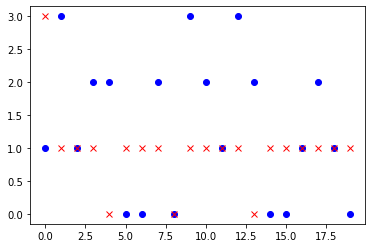

(10, 8)
Acurácia 12.5 %


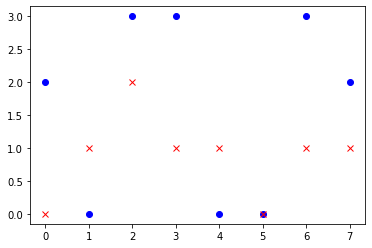

In [61]:
vote_acc_test(df_k1, 'k1')
vote_acc_leave_out(df_k1)

(10, 20)
Acurácia 25.0 %


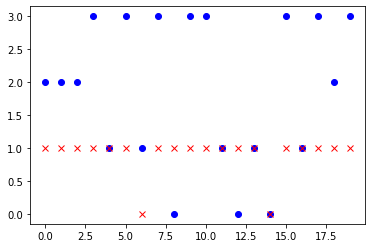

(10, 8)
Acurácia 0.0 %


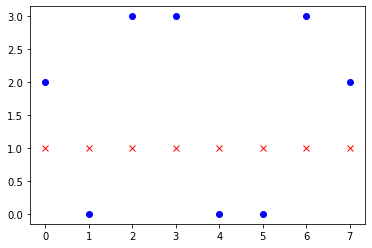

In [62]:
vote_acc_test(df_k2, 'k2')
vote_acc_leave_out(df_k2)

(10, 20)
Acurácia 40.0 %


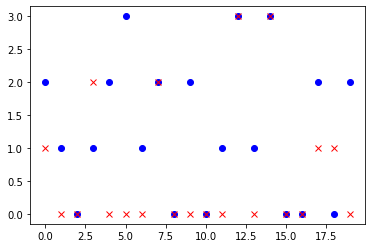

(10, 8)
Acurácia 37.5 %


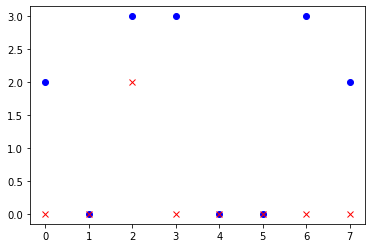

In [63]:
vote_acc_test(df_k3, 'k3')
vote_acc_leave_out(df_k3)

(10, 20)
Acurácia 20.0 %


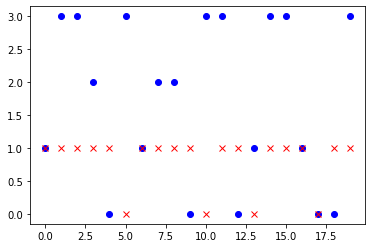

(10, 8)
Acurácia 50.0 %


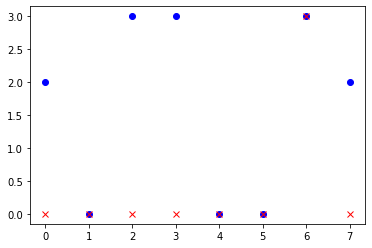

In [64]:
vote_acc_test(df_k4, 'k4')
vote_acc_leave_out(df_k4)

(10, 20)
Acurácia 45.0 %


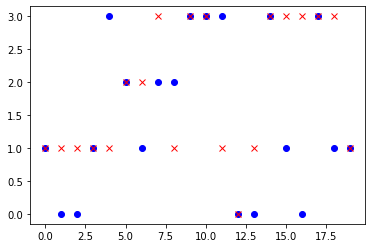

(10, 8)
Acurácia 0.0 %


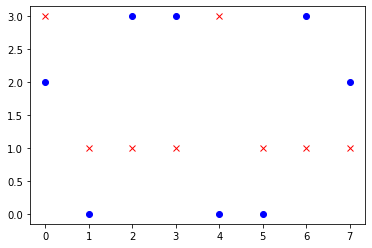

In [65]:
vote_acc_test(df_k5, 'k5')
vote_acc_leave_out(df_k5)

(10, 20)
Acurácia 20.0 %


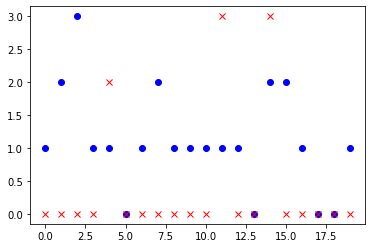

(10, 8)
Acurácia 25.0 %


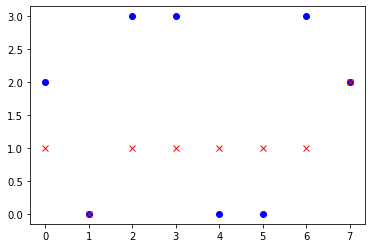

In [66]:
vote_acc_test(df_k6, 'k6')
vote_acc_leave_out(df_k6)

(10, 20)
Acurácia 25.0 %


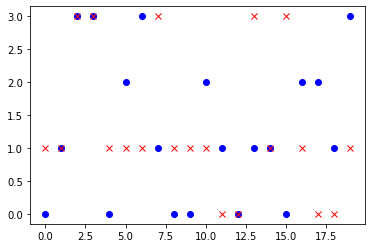

(10, 8)
Acurácia 25.0 %


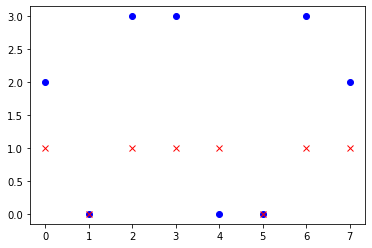

In [67]:
vote_acc_test(df_k7, 'k7')
vote_acc_leave_out(df_k7)

(10, 20)
Acurácia 25.0 %


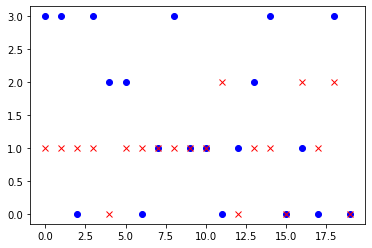

(10, 8)
Acurácia 37.5 %


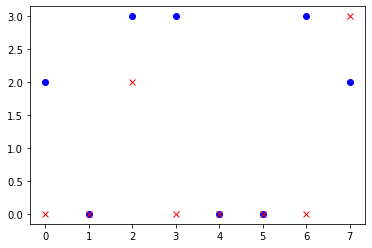

In [68]:
vote_acc_test(df_k8, 'k8')
vote_acc_leave_out(df_k8)

(10, 20)
Acurácia 20.0 %


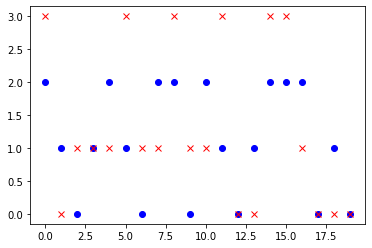

(10, 8)
Acurácia 37.5 %


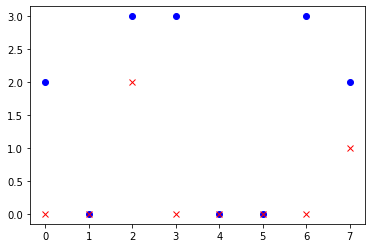

In [69]:
vote_acc_test(df_k9, 'k9')
vote_acc_leave_out(df_k9)

(10, 19)
Acurácia 31.57894736842105 %


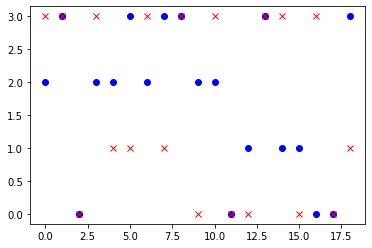

(10, 8)
Acurácia 62.5 %


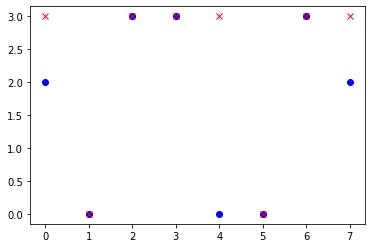

In [70]:
vote_acc_test(df_k10, 'k10')
vote_acc_leave_out(df_k10)